# About
* Created by: Piramol Krishnan
* Created on : 10 Aug 2021
* Goal: Document useful functions and then execute them using Biffa pipeline data

In [2]:
import pandas as pd
import numpy as np

## 1. Pipe()

### What is it used for
    * Used for data cleaning/ preprocessing 

### What does it do?
    * chain multiple custom functions into a single operation
* E.g.
    * drop_duplicates, remove_outliers, encode_categoricals -> they all accept their own arguements
* Below is how you apply all three in a single operation

### How to apply
```
df_preped = (diamonds.pipe(drop_duplicates).
                      pipe(remove_outliers, ['price','carat','depth']).
                      pipe(encode_categoricals, ['cut','color','clarity'])

```

In [14]:
# try with actual data
df = pd.DataFrame({
   "id": [100, 100, 101, 102, 103, 104, 105, 106],
   "A": [1, 2, 3, 4, 5, 2, np.nan, 5],
   "B": [45, 56, 48, 47, 62, 112, 54, 49],
   "C": [1.2, 1.4, 1.1, 1.8, np.nan, 1.4, 1.6, 1.5]
})
df

,id,A,B,C
0,100,1.0,45,1.2
1,100,2.0,56,1.4
2,101,3.0,48,1.1
3,102,4.0,47,1.8
4,103,5.0,62,NaN
5,104,2.0,112,1.4
6,105,NaN,54,1.6
7,106,5.0,49,1.5


## Remarks
* There are some NaNs that need to be removed/dealt with
*  There are duplicate values in the id column
* The value '112' in column B might be an outlier
* To deal with each task, we need a function
    * each function needs to take a dataframe as an argument and return a dataframe

In [5]:
## replace missing values with the mean value of the column
def fill_missing_values(df):
    for col in df.select_dtypes(include=["int","float"]).columns:
        val = df[col].mean()
        df[col].fillna(val, inplace=True)
    return df

In [6]:
# pandas has its own inbuilt drop_duplicates function, in the following function we also take column name as an arg
def drop_duplicates(df, column_name):
    df = df.drop_duplicates(subset=column_name)
    return df

In [7]:
def remove_outliers(df,column_list):
    for col in column_list:
        avg = df[col].mean()
        std = df[col].std()
        low = avg - 2*std             #lowerbound
        high = avg + 2*std            #upperbound
        df = df[df[col].between(low,high, inclusive=True)]     #only keep those in the range
    return df

In [8]:
## now apply with the pipe func
df_processed = (df.
                pipe(fill_missing_values).
                pipe(drop_duplicates, "id").
                pipe(remove_outliers, ["A","B"]))

### Remarks
* the pipe executes the functions in the given order
* so we can pass the arguments to the pipe along with the function names
* the original dataframe will be updated along the pipe
    * to work around this, use a copy of the original df (if you want to keep the og df)
    * otherwise just use the pipe

In [11]:
my_df = df.copy()
df_processed = (my_df.
                pipe(fill_missing_values).
                pipe(drop_duplicates, "id").
                pipe(remove_outliers, ["A","B"]))

In [15]:
df

,id,A,B,C
0,100,1.0,45,1.2
1,100,2.0,56,1.4
2,101,3.0,48,1.1
3,102,4.0,47,1.8
4,103,5.0,62,NaN
5,104,2.0,112,1.4
6,105,NaN,54,1.6
7,106,5.0,49,1.5


In [16]:
df_processed

,id,A,B,C
0,100,1.000000,45,1.200000
2,101,3.000000,48,1.100000
3,102,4.000000,47,1.800000
4,103,5.000000,62,1.428571
6,105,3.142857,54,1.600000
7,106,5.000000,49,1.500000


---
## 2.Function: factorize()

### What is it?

* pandas alternative to sklearn's labelencoder
```
# mind the [0] at the end
diamonds["cut_enc"] = pd.factorize(diamonds["cut"])[0]

diamonds["cut_enc"].sample(5)

```

* factorize returns a tuple of two values: the encoded column and a list of the unique categories

```
codes, unique = pd.factorize(diamonds["cut"],sort=True)

codes[:10]
> array([0, 1, 3, 1, 3, 2, 2, 2, 4, 2], dtype=int64)

unique
>['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
```

----
## 3. Function: explode()

In [18]:
# create some data first
data = pd.Series([1, 6, 7, [46, 56, 49], 45, [15, 10, 12]]).to_frame("dirty")

data

,dirty
0,1
1,6
2,7
3,"[46, 56, 49]"
4,45
5,"[15, 10, 12]"


####  in the dirty column, there are 2 rows where values are recorded as lists
* let's make it more uniform

In [19]:
data.explode("dirty",ignore_index=True)

,dirty
0,1
1,6
2,7
3,46
4,56
5,49
6,45
7,15
8,10
9,12


### what did explode do?
* it takes a cell with an array-like value and explodes it into multiple rows
* set `ignore_index` to True to keep the ordering of a numeric index

---
## 4. Squeeze
* used in rare but annoying edge cases

```
subset = diamonds.loc[diamonds.index < 1, ["price"]]

```
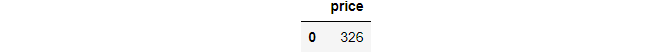

* it's only one cell but is returned as a dataframe
    * annoying -> need to use .loc again with both column name and index
* but with squeeze(), you can remove an axis from a single-cell dateframe or series
    * only a scalar is returned
    * you can also specify the axis

```
subset.squeeze("columns")   # or rows
```
* but note that squeeze only works for dataframes/series with single values

---
## 5. Between
* function for boolean indexing numeric features within a range

```
# Get diamonds that are priced between 3500 and 3700 dollars
diamonds[diamonds["price"]\
      .between(3500, 3700, inclusive="neither")].sample(5)
```

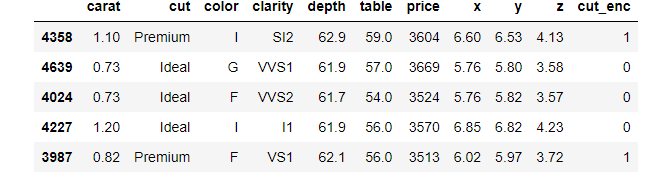



---
## 6. T

* transpose
* useful especially when displaying dataframes of the describe method
    ` boston.describe().T.head(10)`

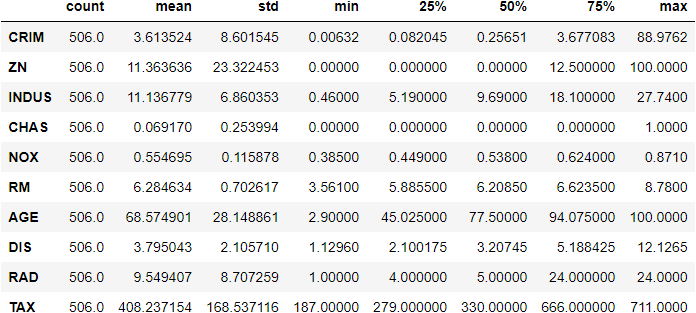

* The Boston housing dataset has 30 numeric columns. 
* If you call describe as-is, the DataFrame will stretch horizontally, making it hard to compare the statistics. Taking the transpose will switch the axes so that summary statistics are given in columns.

----
## 7. Describe() method
* is used to view some basic statistical details like percentile/mean/std etc
* can specify the percentiles
    * i.e. `perc = [0.20,0.40,0.60,0.80]`
* specify the list of dtypes to include
    * `include = ['object', 'float','int']`

    `desc = data.describe(percentiles = perc, include = include)`
### how about series of strings? 

In [22]:
## import
data = pd.read_csv('nba (1).csv')

# removing null values to avoid errors 
data.dropna(inplace = True) 
  
# calling describe method
desc = data["Name"].describe()
  
# display
desc

count                         364
unique                        364
top       Rondae Hollis-Jefferson
freq                            1
Name: Name, dtype: object

## Pandas Styler